# Scrip para la competencia 01

Back-testing

Incluye:

- Tuning de hyperparámetros (con meses históricos)
- Análisis de la incertidumbre (respecto a la proyección histórica)
- Predicción para entrega (competancia de Kaggle)

## Directorios

In [1]:
import os
import pandas as pd

datos = 'datos'

optimizacion = 'optimizacion'

modelos = 'modelos'


## Datos

La creación del target y el análisis exploratorio, está avanzado en el Notebook_comp01.

Se deberá continuar con esto, para diseñar el ejercicio de story-telling sobre "porqué se van los clientes?"

In [2]:
dataset_file = 'competencia_01_brandoni_fe_agr_1.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

C:\Users\santt\AppData\Local\Temp\ipykernel_2080\3977231585.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


Si exploramos la variable foto_mes:

In [3]:
data.foto_mes.value_counts().sort_index()

foto_mes
202101    162026
202102    162646
202103    163685
202104    164090
202105    164623
202106    164876
Name: count, dtype: int64

Vemos que podemos entrenar con predicciones:

- enero a marzo
- febrero a abril
- marzo a mayo
- abril a junio

A continuación se trabaja con **febrero a abril** para entrenar.

Luego, **abril a junio** para testear y validar.

### Condiciones de la prueba

In [4]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

# DQ + DD
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

## Pipeline

Con distintos modelos

In [5]:
# !pip install xgboost

In [6]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# Definir la clase ModelPipeline
class ModelPipeline:
    def __init__(self, data, seeds, model_type='lightgbm', 
                 ganancia_acierto=273000, costo_estimulo=7000, 
                 threshold=0.025, seed=0, n_jobs=-1, reg=False):
        self.data = data
        self.seeds = seeds
        self.s = seed
        self.n_jobs = int(n_jobs)
        self.model_type = model_type
        self.ganancia_acierto = ganancia_acierto
        self.costo_estimulo = costo_estimulo
        self.threshold = threshold
        self.reg = reg
        self.models = {}
        self.base_params = {'random_state': self.seeds[self.s]}
        self.best_params = None
        self.base_model = None
        self.best_model = None

        # Mapear model_type al clasificador correspondiente
        self.classifier_map = {
            'xgboost': XGBClassifier,
            'lightgbm': LGBMClassifier
        }

    def def_xy(self, mes, target='clase_ternaria', to_pred=False):
        X = self.data[self.data['foto_mes'] == mes]
        y = X[target]
        X = X.drop(columns=[target])

        numero_de_cliente = X['numero_de_cliente']

        if to_pred:
            return X, numero_de_cliente
        else:
            return X, y

    def ganancia(self, model, X, y, prop=1):
        # Obtener las probabilidades predichas
        y_hat = model.predict_proba(X)

        # Obtener las clases del modelo
        model_classes = model.classes_

        # Identificar la clase objetivo (puede ser 'BAJA+2' o 2)
        if 'BAJA+2' in model_classes:
            target_class = 'BAJA+2'
        elif 2 in model_classes:
            target_class = 2
        else:
            raise ValueError("La clase objetivo 'BAJA+2' o 2 no está en las clases del modelo.")

        # Obtener el índice de la clase objetivo
        class_index = np.where(model_classes == target_class)[0][0]

        # Obtener las probabilidades predichas para la clase objetivo
        probs = y_hat[:, class_index]

        # Calcular la ganancia para cada fila
        gains = np.where(
            probs >= self.threshold,
            np.where(y == target_class, self.ganancia_acierto, -self.costo_estimulo),
            0
        )

        # Sumar las ganancias
        estimated_gain = gains.sum()/prop

        return estimated_gain

    def train_and_evaluate(self, train_index, test_index, X, y, params):
        # Instanciar el clasificador basado en model_type
        classifier_class = self.classifier_map[self.model_type]
        model = classifier_class(**params)
        model.fit(X.iloc[train_index], y.iloc[train_index])
        ganancia_value = self.ganancia(model, X.iloc[test_index], y.iloc[test_index], prop=0.3)
        return model, ganancia_value

    def optimize_model(self, X, y, storage_name, study_name, optimize=True, n_trials=200):
        sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=self.seeds[self.s])

        def objective_xgboost(self, trial):
            # Hiperparámetros para XGBClassifier

            # Parámetros a optimizar
            # n_estimators = trial.suggest_int('n_estimators', 100, 500)
            max_leaves = trial.suggest_int('max_leaves', 10, 256)
            learning_rate = trial.suggest_float('eta', 0.01, 0.3, log=True)  # 'eta' es equivalente a 'learning_rate'
            gamma = trial.suggest_float('gamma', 0, 5)
            min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            if self.reg:
                reg_lambda = trial.suggest_float('lambda', 0.0, 10.0)
                reg_alpha = trial.suggest_float('alpha', 0.0, 10.0)
            # scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

            params = {
                'booster': 'gbtree',
                'n_estimators': 100,
                'max_leaves': max_leaves,
                'learning_rate': learning_rate,
                'gamma': gamma,
                'min_child_weight': min_child_weight,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree,
                # 'scale_pos_weight': scale_pos_weight, # default = 1, ya que la ganancia ya contempla desbalance
                'random_state': self.seeds[self.s],
                'enable_categorical': True,
                'use_label_encoder': False,
                'objective': 'multi:softprob',
                'num_class': 3,
                'eval_metric': 'mlogloss',
                'tree_method': 'hist',      # Usar 'hist' para grandes conjuntos de datos
                'grow_policy': 'lossguide', # Necesario cuando se usa 'max_leaves'
            }

            if self.reg:
                params.update({
                    'reg_lambda': reg_lambda,  # 'lambda' es palabra reservada en Python, usamos 'reg_lambda'
                    'reg_alpha': reg_alpha,
                })

            # Ejecutar validación cruzada paralela
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.train_and_evaluate)(train_index, test_index, X, y, params)
                for train_index, test_index in sss_opt.split(X, y)
            )

            # Retornar la ganancia media
            return np.mean([result[1] for result in results])

        def objective_lightgbm(self, trial):
            # Hiperparámetros para LGBMClassifier
            # n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            num_leaves = trial.suggest_int('num_leaves', 31, 256)
            # max_depth = trial.suggest_int('max_depth', -1, 30) # conflict with num_leaves
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
            min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 20, 100)
            if self.reg:
                lambda_l1 = trial.suggest_float('lambda_l1', 0.0, 10.0)
                lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 10.0)
            min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.0, 1.0)
            feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
            bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
            bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
            max_bin = trial.suggest_int('max_bin', 64, 255)

            params = {
                'n_estimators': 100, # to reduce overfitting and training time
                'num_leaves': num_leaves,
                # 'max_depth': max_depth,
                'learning_rate': learning_rate,
                'min_data_in_leaf': min_data_in_leaf,
                'min_gain_to_split': min_gain_to_split,
                'feature_fraction': feature_fraction,
                'bagging_fraction': bagging_fraction,
                'bagging_freq': bagging_freq,
                'max_bin': max_bin,
                # 'objective': 'binary',  # Specify the objective function
                # 'metric': 'binary_logloss',  # Specify the evaluation metric
                'random_state': self.seeds[self.s],
                'n_jobs': self.n_jobs,
                'verbosity': -1,
            }

            if self.reg:
                params.update({
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                })

            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.train_and_evaluate)(train_index, test_index, X, y, params)
                for train_index, test_index in sss_opt.split(X)
            )

            return np.mean([result[1] for result in results])

        # Mapear model_type a la función objetivo correspondiente
        objective_map = {
            'xgboost': objective_xgboost,
            'lightgbm': objective_lightgbm
        }

        objective = objective_map[self.model_type]

        study = optuna.create_study(
            direction="maximize",
            study_name=study_name,
            storage=storage_name,
            load_if_exists=True
        )

        if optimize:
            print(f"Optimizando {self.model_type} con {n_trials} pruebas")
            study.optimize(objective, n_trials=n_trials)

        best_trial = study.best_trial
        self.best_params = best_trial.params  # Guardar los mejores parámetros

        print(f"Mejores parámetros para {self.model_type}: {best_trial.params}")
        return best_trial.params

    def train_base_model(self, X_train, y_train):
        classifier_class = self.classifier_map[self.model_type]
        self.base_model = classifier_class(**self.base_params)
        self.base_model.fit(X_train, y_train)

    def train_best_model(self, X_train, y_train):
        if self.best_params is None:
            print("No se encontraron mejores parámetros. Por favor, ejecuta optimize_model primero.")
            return
        classifier_class = self.classifier_map[self.model_type]
        self.best_model = classifier_class(**self.best_params)
        self.best_model.fit(X_train, y_train)

    def compare_models(self, X, y):
        sss = StratifiedShuffleSplit(n_splits=30, test_size=0.3, random_state=self.seeds[self.s])

        results_base = Parallel(n_jobs=self.n_jobs)(
            delayed(self.train_and_evaluate)(train_index, test_index, X, y, self.base_params)
            for train_index, test_index in sss.split(X, y)
        )
        results_best = Parallel(n_jobs=self.n_jobs)(
            delayed(self.train_and_evaluate)(train_index, test_index, X, y, self.best_params)
            for train_index, test_index in sss.split(X, y)
        )

        return results_base, results_best

    def plot_comparisons(self, results_base, results_best):
        df_pred = pd.DataFrame({'Ganancia': [result[1] for result in results_base], 'Modelo': 'Base'})
        df_pred_best = pd.DataFrame({'Ganancia': [result[1] for result in results_best], 'Modelo': 'Best'})
        df_combined = pd.concat([df_pred, df_pred_best])

        g = sns.FacetGrid(df_combined, row="Modelo", aspect=2)
        g.map(sns.histplot, "Ganancia", kde=True)
        plt.show()

        mean_base = df_combined[df_combined['Modelo'] == 'Base']['Ganancia'].mean()
        mean_best = df_combined[df_combined['Modelo'] == 'Best']['Ganancia'].mean()

        print(f"Ganancia media del modelo base: {mean_base}")
        print(f"Ganancia media del modelo Best: {mean_best}")

    def test_model(self, model, X, y):
        ganancia_test = self.ganancia(model, X, y)
        print(f"Ganancia del modelo en el conjunto de test: {ganancia_test}")
        return ganancia_test

    def test_base_model(self, X, y):
        return self.test_model(self.base_model, X, y)

    def test_best_model(self, X, y):
        return self.test_model(self.best_model, X, y)

    def simulate_kaggle_split(self, mes_futuro, imputer=None, to_drop=None):
        """
        Simula el split público/privado como en una competencia de Kaggle.
        """
        # Obtener los datos futuros
        X_futuro, y_futuro = self.def_xy(mes_futuro, target='clase_ternaria', to_pred=False)
        if to_drop is not None:
            X_futuro = X_futuro.drop(columns=to_drop)
        if imputer is not None:
            X_futuro = pd.DataFrame(imputer.transform(X_futuro), columns=X_futuro.columns)

        # Simular el split público/privado
        sss_futuro = StratifiedShuffleSplit(n_splits=50, test_size=0.3, random_state=self.seeds[self.s])

        gan_fut_priv_best = []
        gan_fut_priv_base = []
        gan_fut_pub_best = []
        gan_fut_pub_base = []

        for train_index, test_index in sss_futuro.split(X_futuro, y_futuro):
            # Privado (70% de los datos)
            gan_fut_priv_best.append(
                self.ganancia(self.best_model, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7)
            )
            gan_fut_priv_base.append(
                self.ganancia(self.base_model, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7)
            )
            # Público (30% de los datos)
            gan_fut_pub_best.append(
                self.ganancia(self.best_model, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3)
            )
            gan_fut_pub_base.append(
                self.ganancia(self.base_model, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3)
            )

        # Crear DataFrames para visualización
        df_pred_1_best = pd.DataFrame({
            'Ganancia': gan_fut_priv_best,
            'Modelo': 'Best',
            'Grupo': 'Privado'
        })
        df_pred_2_best = pd.DataFrame({
            'Ganancia': gan_fut_pub_best,
            'Modelo': 'Best',
            'Grupo': 'Publico'
        })
        df_pred_1_base = pd.DataFrame({
            'Ganancia': gan_fut_priv_base,
            'Modelo': 'Base',
            'Grupo': 'Privado'
        })
        df_pred_2_base = pd.DataFrame({
            'Ganancia': gan_fut_pub_base,
            'Modelo': 'Base',
            'Grupo': 'Publico'
        })

        df_combined = pd.concat([df_pred_1_base, df_pred_2_base, df_pred_1_best, df_pred_2_best])

        # Visualización
        g = sns.FacetGrid(df_combined, col="Grupo", row="Modelo", aspect=2)
        g.map(sns.histplot, "Ganancia", kde=True)
        plt.show()

        # Cálculo de ganancias medias
        mean_base_privado = df_combined[
            (df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Privado')
        ]['Ganancia'].mean()
        mean_base_publico = df_combined[
            (df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Publico')
        ]['Ganancia'].mean()
        mean_best_privado = df_combined[
            (df_combined['Modelo'] == 'Best') & (df_combined['Grupo'] == 'Privado')
        ]['Ganancia'].mean()
        mean_best_publico = df_combined[
            (df_combined['Modelo'] == 'Best') & (df_combined['Grupo'] == 'Publico')
        ]['Ganancia'].mean()

        print(f"Ganancia media del modelo base en privado: {mean_base_privado}")
        print(f"Ganancia media del modelo base en público: {mean_base_publico}")
        print(f"Ganancia media del modelo Best en privado: {mean_best_privado}")
        print(f"Ganancia media del modelo Best en público: {mean_best_publico}")

        return gan_fut_priv_best, \
                gan_fut_priv_base, \
                gan_fut_pub_best, \
                gan_fut_pub_base

## Modelos candidatos


> lightgbm aggressive FE 3 cleaned

> xgboost aggressive FE 3 cleaned

> xgboost aggressive FE 3 cleaned and reg

Estos probaron superar a los árboles, el RF y a versiones con FE reducida. 
Mas info en: 

Script_comp01_v02_pipeline_training

Script_comp01_v02_pipeline_training_old


Ahora probaremos estos modelos entrenados en febrero 202102 y analizaremos su capacidad de generalizar contra abril 202104.

### Lightgbm aggressive FE 3 cleaned

Entreno en febrero

Con mes test abril

Como febrero no puede trabajar con FE 3, trabajamos con FE 1.

### Corriendo pipeline con LightGBM ###
Columns with all NaN values: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24204
[LightGBM] [Info] Number of data points in the train set: 162646, number of used features: 212
[LightGBM] [Info] Start training from score -5.333648
[LightGBM] [Info] Start training from score -5.074719
[LightGBM] [Info] 

[I 2024-10-10 19:51:31,738] Using an existing study with name 'comp01_v02_pipeline_backtest_lightgbm_fe_agr_1' instead of creating a new one.


Mejores parámetros para lightgbm: {'num_leaves': 31, 'learning_rate': 0.02303104785530692, 'min_data_in_leaf': 65, 'min_gain_to_split': 0.9506884285738473, 'feature_fraction': 0.742077563610891, 'bagging_fraction': 0.8633714323057383, 'bagging_freq': 2, 'max_bin': 88}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.742077563610891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.742077563610891
[LightGBM] [Warning] min_gain_to_split is set=0.9506884285738473, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9506884285738473
[LightGBM] [Warning] bagging_fraction is set=0.8633714323057383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8633714323057383
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: baggin

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


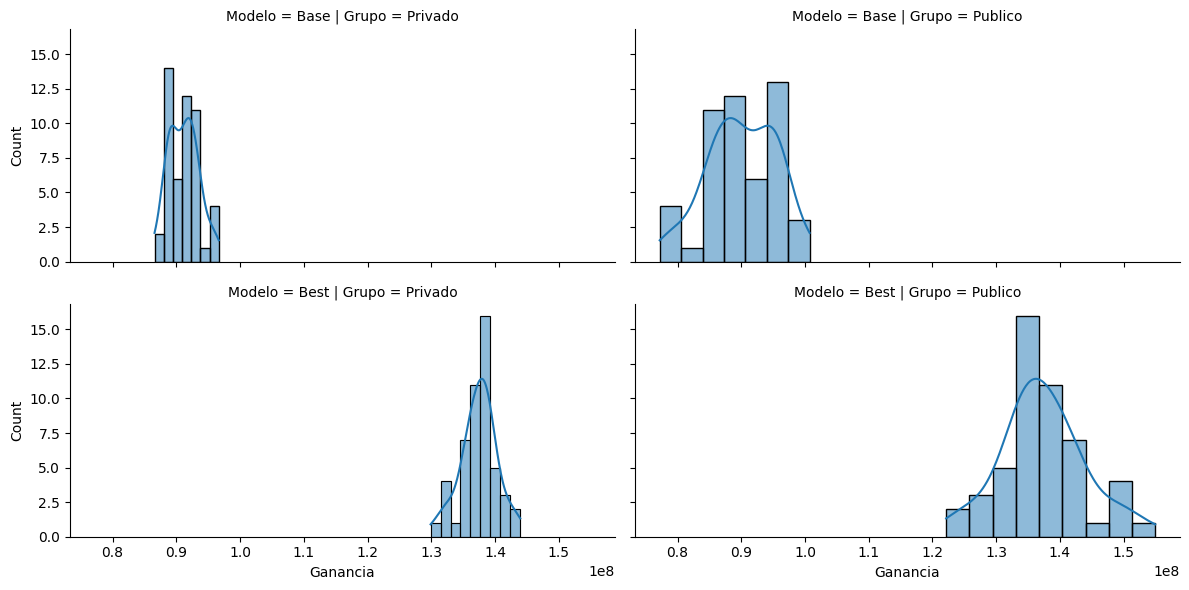

Ganancia media del modelo base en privado: 91143400.0
Ganancia media del modelo base en público: 90082066.66666666
Ganancia media del modelo Best en privado: 137453200.0
Ganancia media del modelo Best en público: 137332533.33333337


In [7]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_fe1_c = ModelPipeline(data, semillas, model_type='lightgbm', seed=s, n_jobs=-1)
X_train, y_train = pipeline_lgbm_fe1_c.def_xy(mes_train)
X_test, y_test = pipeline_lgbm_fe1_c.def_xy(mes_test)

# Identify columns with all NaN values
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columns with all NaN values:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)


# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_test.columns)

# Opcional: Codificar variables categóricas
# LightGBM puede manejar variables categóricas directamente si se especifican
# Si tus datos tienen variables categóricas, puedes identificarlas y especificarlas en el modelo
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_fe1_c.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_fe1_c.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_lgbm = "sqlite:///optimizacion/optimization_tree.db"
study_lgbm = "comp01_v02_pipeline_backtest_lightgbm_fe_agr_1"

print("\n# Optimizando el modelo")
pipeline_lgbm_fe1_c.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_lgbm,
    study_name=study_lgbm,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_fe1_c.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_fe1_c.test_best_model(X_test_imp, y_test)

# # Comparar modelos
# print("\n# Comparando modelos")
# results_base_lgbm, results_best_lgbm = pipeline_lgbm_fe1_c.compare_models(X_train_imp, y_train)
# pipeline_lgbm_fe1_c.plot_comparisons(results_b
# ase_lgbm, results_best_lgbm)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lightgbm_fe_agr_1, fpri_base_lightgbm_fe_agr_1, \
fpub_best_lightgbm_fe_agr_1, fpub_base_lightgbm_fe_agr_1 = \
pipeline_lgbm_fe1_c.simulate_kaggle_split(mes_futuro=mes_test, imputer=imp_median,
                                          to_drop=to_drop)

### Xgboost aggressive FE 3 cleaned

Entreno en febrero

Con mes test abril

Como febrero no puede trabajar con FE 3, trabajamos con FE 1.

In [7]:
# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

In [8]:
max_jobs = os.cpu_count() - 4

### Corriendo pipeline con XGBoost ###
Columns with all NaN values: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']

# Entrenando el modelo base xgb

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 126119000.0

# Optimizando el modelo


[I 2024-10-11 08:14:29,129] Using an existing study with name 'comp01_v02_pipeline_backtest_xgb_fe_agr_1' instead of creating a new one.


Mejores parámetros para xgboost: {'max_leaves': 90, 'eta': 0.09900865169783149, 'gamma': 0.9164105895669479, 'min_child_weight': 6, 'subsample': 0.7858363423228442, 'colsample_bytree': 0.7998556372427564}

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 137767000.0

# Simulando el split Kaggle y comparando modelos


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


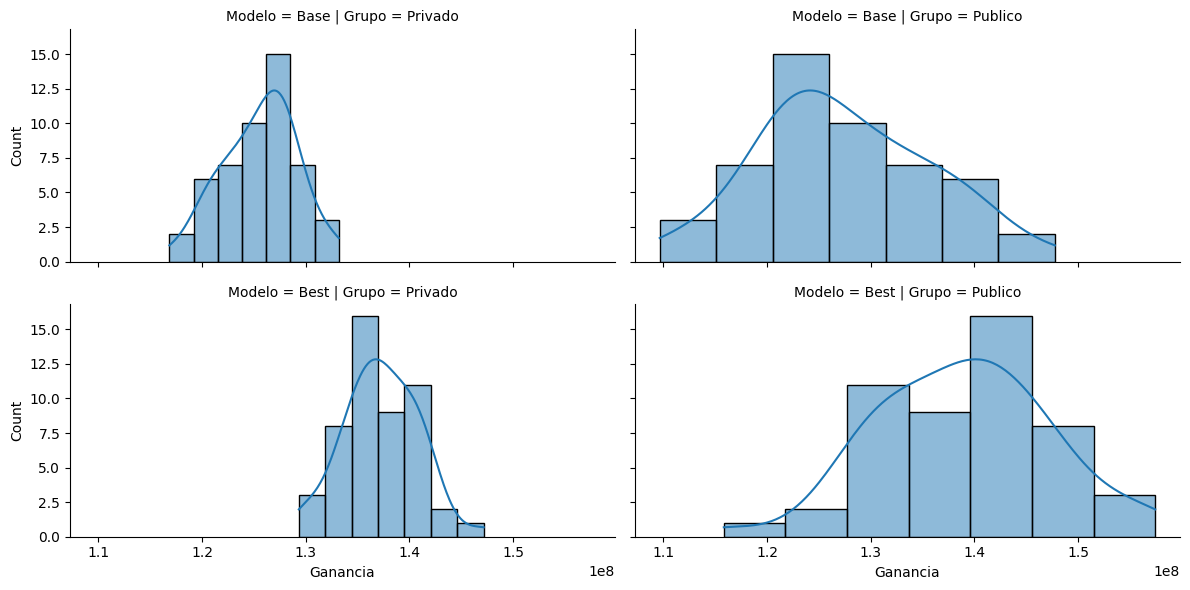

Ganancia media del modelo base en privado: 125554800.0
Ganancia media del modelo base en público: 127435466.66666669
Ganancia media del modelo Best en privado: 137301200.0
Ganancia media del modelo Best en público: 138853866.6666667


In [9]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgb'
pipeline_xgb_fe1_c = ModelPipeline(data, semillas, model_type='xgboost', seed=s, n_jobs=max_jobs)
X_train, y_train = pipeline_xgb_fe1_c.def_xy(mes_train)
X_test, y_test = pipeline_xgb_fe1_c.def_xy(mes_test)

# Identify columns with all NaN values
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columns with all NaN values:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_test.columns)

# Opcional: Codificar variables categóricas
# xgb puede manejar variables categóricas directamente si se especifican
# Si tus datos tienen variables categóricas, puedes identificarlas y especificarlas en el modelo
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para xgb
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

print("\n# Entrenando el modelo base xgb")
pipeline_xgb_fe1_c.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_fe1_c.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_lgbm = "sqlite:///optimizacion/optimization_tree.db"
study_lgbm = "comp01_v02_pipeline_backtest_xgb_fe_agr_1"

print("\n# Optimizando el modelo")
pipeline_xgb_fe1_c.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_lgbm,
    study_name=study_lgbm,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_fe1_c.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_fe1_c.test_best_model(X_test_imp, y_test)

# # Comparar modelos
# print("\n# Comparando modelos")
# results_base_lgbm, results_best_lgbm = pipeline_xgb_fe1_c.compare_models(X_train_imp, y_train)
# pipeline_xgb_fe1_c.plot_comparisons(results_b
# ase_lgbm, results_best_lgbm)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_fe_agr_1, fpri_base_xgb_fe_agr_1, \
fpub_best_xgb_fe_agr_1, fpub_base_xgb_fe_agr_1 = \
pipeline_xgb_fe1_c.simulate_kaggle_split(mes_futuro=mes_test, imputer=imp_median,
                                          to_drop=to_drop)

### Xgboost aggressive FE 3 cleaned + reg

Entreno en febrero

Con mes test abril

Como febrero no puede trabajar con FE 3, trabajamos con FE 1.

### Corriendo pipeline con XGBoost ###
Columns with all NaN values: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']

# Entrenando el modelo base xgb

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 126119000.0

# Optimizando el modelo


[I 2024-10-11 11:17:46,294] Using an existing study with name 'comp01_v02_pipeline_backtest_xgb_fe_agr_1_reg' instead of creating a new one.


Mejores parámetros para xgboost: {'max_leaves': 220, 'eta': 0.12210534479670472, 'gamma': 2.227430285558128, 'min_child_weight': 9, 'subsample': 0.9028187400341684, 'colsample_bytree': 0.9877601430782614, 'lambda': 1.6972982936590508, 'alpha': 0.0075416015678317905}

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 138243000.0

# Simulando el split Kaggle y comparando modelos


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


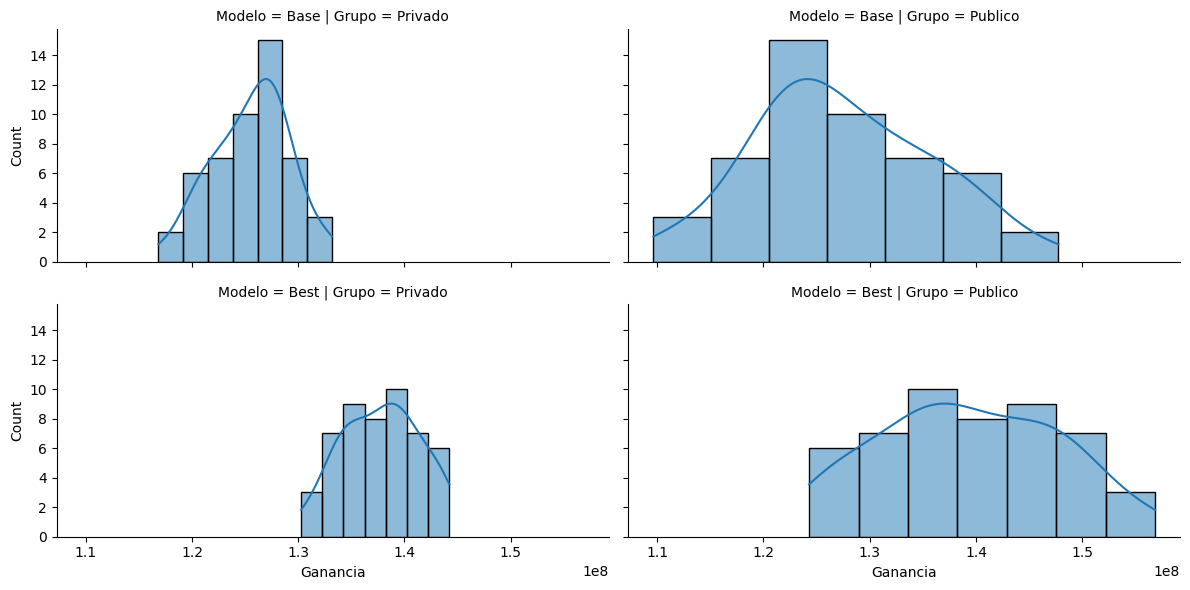

Ganancia media del modelo base en privado: 125554800.0
Ganancia media del modelo base en público: 127435466.66666669
Ganancia media del modelo Best en privado: 137813000.0
Ganancia media del modelo Best en público: 139246333.3333333


In [9]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgb'
pipeline_xgb_fe1_reg = ModelPipeline(data, semillas, model_type='xgboost', 
                                     seed=s, n_jobs=max_jobs+2, reg=True)

X_train, y_train = pipeline_xgb_fe1_reg.def_xy(mes_train)
X_test, y_test = pipeline_xgb_fe1_reg.def_xy(mes_test)

# Identify columns with all NaN values
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columns with all NaN values:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_test.columns)

# Opcional: Codificar variables categóricas
# xgb puede manejar variables categóricas directamente si se especifican
# Si tus datos tienen variables categóricas, puedes identificarlas y especificarlas en el modelo
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para xgb
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

print("\n# Entrenando el modelo base xgb")
pipeline_xgb_fe1_reg.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_fe1_reg.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
storage_lgbm = "sqlite:///optimizacion/optimization_tree.db"
study_lgbm = "comp01_v02_pipeline_backtest_xgb_fe_agr_1_reg"

print("\n# Optimizando el modelo")
pipeline_xgb_fe1_reg.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_lgbm,
    study_name=study_lgbm,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_fe1_reg.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_fe1_reg.test_best_model(X_test_imp, y_test)

# # Comparar modelos
# print("\n# Comparando modelos")
# results_base_lgbm, results_best_lgbm = pipeline_xgb_fe1_reg.compare_models(X_train_imp, y_train)
# pipeline_xgb_fe1_reg.plot_comparisons(results_b
# ase_lgbm, results_best_lgbm)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_fe_agr_1_reg, fpri_base_xgb_fe_agr_1_reg, \
fpub_best_xgb_fe_agr_1_reg, fpub_base_xgb_fe_agr_1_reg = \
pipeline_xgb_fe1_reg.simulate_kaggle_split(mes_futuro=mes_test, imputer=imp_median,
                                          to_drop=to_drop)

## Comparación de modelos 

Distintos pipelines en sus pruebas de backtesting

In [22]:
def plot_comparisons_on_kaggle_split(name_model_a, results_a_priv, results_a_pub,
                     name_model_b, results_b_priv, results_b_pub, 
                     alfa=0.05):
    
    print(f"Comparando modelos: {name_model_a} vs. {name_model_b}")

    df_pred_a_priv = pd.DataFrame({'Ganancia': results_a_priv, 
                                   'Modelo': f'{name_model_a}_best',
                                   'Grupo': 'Privado'})
    df_pred_a_pub = pd.DataFrame({'Ganancia': results_a_pub, 
                                'Modelo': f'{name_model_a}_best',
                                'Grupo': 'Publico'})
    df_pred_b_priv = pd.DataFrame({'Ganancia': results_b_priv, 
                                   'Modelo': f'{name_model_b}_best',
                                   'Grupo': 'Privado'})
    df_pred_b_pub = pd.DataFrame({'Ganancia': results_b_pub, 
                                'Modelo': f'{name_model_b}_best',
                                'Grupo': 'Publico'})
    
    df_combined = pd.concat([df_pred_a_priv, df_pred_a_pub, df_pred_b_priv, df_pred_b_pub])

    # Gráfico de las distribuciones
    g = sns.FacetGrid(df_combined, col="Grupo", row="Modelo", aspect=2)
    g.map(sns.histplot, "Ganancia", kde=True)
    plt.show()

    # Cálculo de ganancias medias
    mean_pred_a_priv = df_combined[
        (df_combined['Modelo'] == f'{name_model_a}_best') & (df_combined['Grupo'] == 'Privado')
    ]['Ganancia'].mean()
    mean_pred_a_pub = df_combined[
        (df_combined['Modelo'] == f'{name_model_a}_best') & (df_combined['Grupo'] == 'Publico')
    ]['Ganancia'].mean()
    mean_pred_b_priv = df_combined[
        (df_combined['Modelo'] == f'{name_model_b}_best') & (df_combined['Grupo'] == 'Privado')
    ]['Ganancia'].mean()
    mean_pred_b_pub = df_combined[
        (df_combined['Modelo'] == f'{name_model_b}_best') & (df_combined['Grupo'] == 'Publico')
    ]['Ganancia'].mean()

    print(f"Ganancia media del modelo {name_model_a} privado: {mean_pred_a_priv}")
    print(f"Ganancia media del modelo {name_model_a} publico: {mean_pred_a_pub}")
    print(f"Ganancia media del modelo {name_model_b} privado: {mean_pred_b_priv}")
    print(f"Ganancia media del modelo {name_model_b} publico: {mean_pred_b_pub}")

    # Importar la función para el test estadístico
    from scipy.stats import mannwhitneyu

    # Realizar el test de Mann-Whitney U - Privado
    estadistico_u_priv, p_valor_priv = mannwhitneyu(
        df_pred_a_priv['Ganancia'], df_pred_b_priv['Ganancia'], alternative='less'
    )

    # Mostrar los resultados del test
    print(f"\nResultado del test estadístico Mann-Whitney U (privado):")
    print(f"Estadístico U = {estadistico_u_priv}")
    print(f"P-valor = {p_valor_priv}")

    # Interpretación del resultado
    if p_valor_priv < alfa:
        print(f"Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de {name_model_b}_priv es mayor que la de {name_model_a}_priv.")
    else:
        print(f"No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de {name_model_b}_priv es mayor que la de {name_model_a}_priv.")


    # Realizar el test de Mann-Whitney U - Publico
    estadistico_u_pub, p_valor_pub = mannwhitneyu(
        df_pred_a_pub['Ganancia'], df_pred_b_pub['Ganancia'], alternative='less'
    )

    # Mostrar los resultados del test
    print(f"\nResultado del test estadístico Mann-Whitney U (privado):")
    print(f"Estadístico U = {estadistico_u_pub}")
    print(f"P-valor = {p_valor_pub}")

    # Interpretación del resultado
    if p_valor_priv < alfa:
        print(f"Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de {name_model_b}_pub es mayor que la de {name_model_a}_pub.")
    else:
        print(f"No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de {name_model_b}_pub es mayor que la de {name_model_a}_pub.")

**Modelo lightgbm Aggressive FE 3 cleaned vs. xgboost Aggressive FE 3 cleaned**

Comparando modelos: lightgbm aggressive FE 3 cleaned vs. xgboost aggressive FE 3 cleaned


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


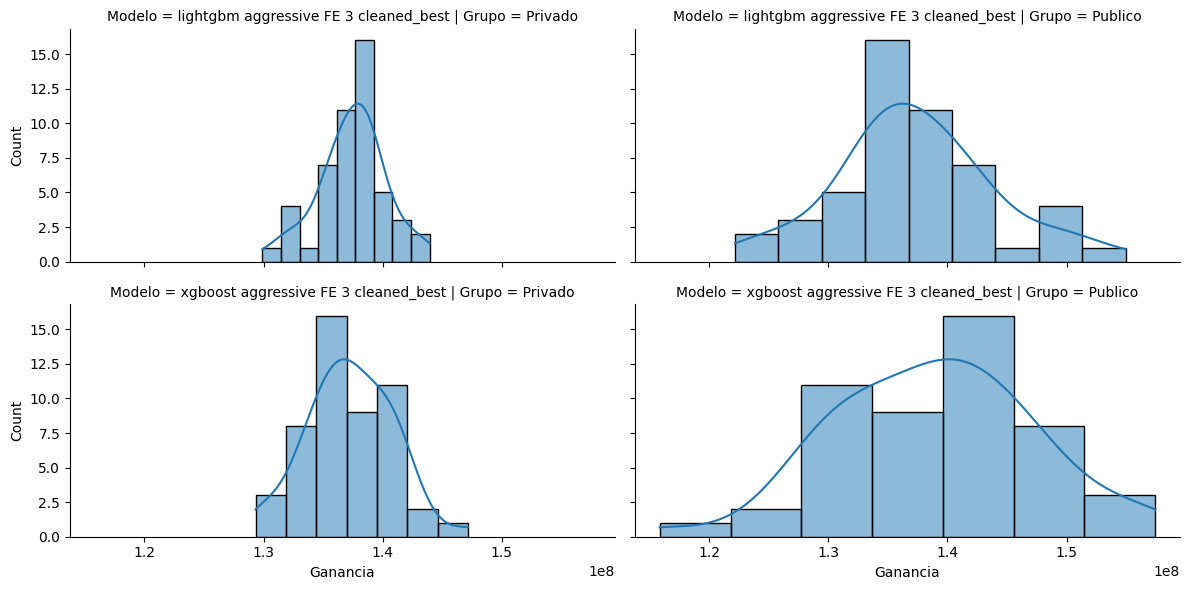

Ganancia media del modelo lightgbm aggressive FE 3 cleaned privado: 137453200.0
Ganancia media del modelo lightgbm aggressive FE 3 cleaned publico: 137332533.33333337
Ganancia media del modelo xgboost aggressive FE 3 cleaned privado: 137301200.0
Ganancia media del modelo xgboost aggressive FE 3 cleaned publico: 138853866.6666667

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1296.5
P-valor = 0.6270364319497208
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgboost aggressive FE 3 cleaned_priv es mayor que la de lightgbm aggressive FE 3 cleaned_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1084.5
P-valor = 0.12766521719320584
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgboost aggressive FE 3 cleaned_pub es mayor que la de lightgbm aggressive FE 3 cleaned_pub.


In [23]:
model_a = "lightgbm aggressive FE 3 cleaned"
model_b = "xgboost aggressive FE 3 cleaned"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lightgbm_fe_agr_1, fpub_best_lightgbm_fe_agr_1,
                                model_b, fpri_best_xgb_fe_agr_1, fpub_best_xgb_fe_agr_1)

**Modelo lightgbm Aggressive FE 3 cleaned vs. xgboost Aggressive FE 3 cleaned + reg**

Comparando modelos: lightgbm aggressive FE 3 cleaned vs. xgboost aggressive FE 3 cleaned + reg


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


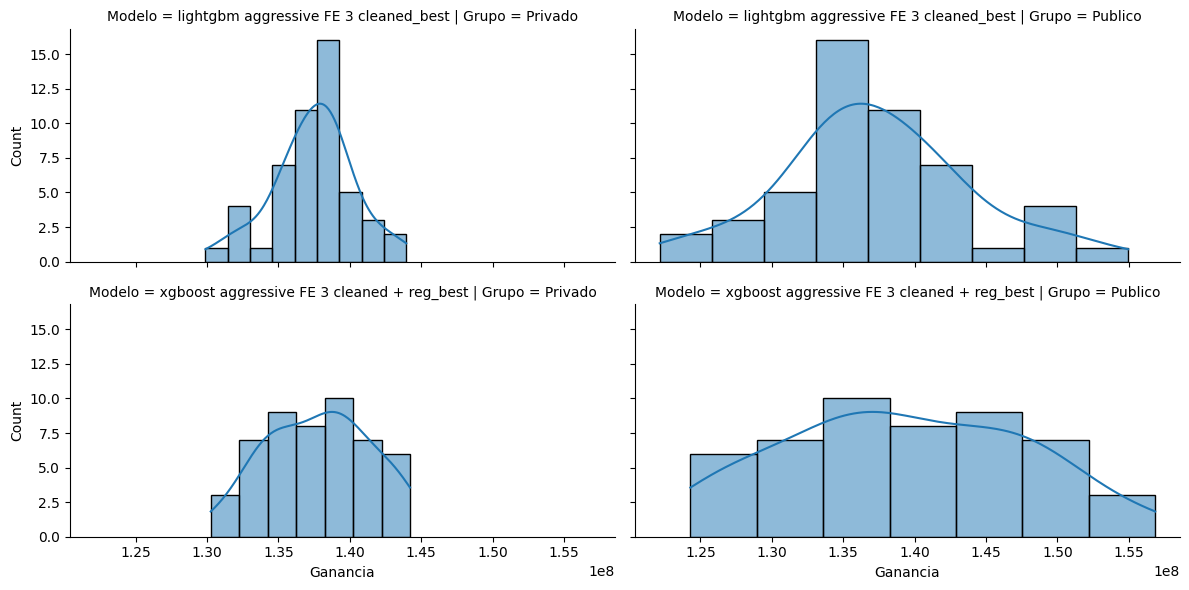

Ganancia media del modelo lightgbm aggressive FE 3 cleaned privado: 137453200.0
Ganancia media del modelo lightgbm aggressive FE 3 cleaned publico: 137332533.33333337
Ganancia media del modelo xgboost aggressive FE 3 cleaned + reg privado: 137813000.0
Ganancia media del modelo xgboost aggressive FE 3 cleaned + reg publico: 139246333.3333333

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1173.0
P-valor = 0.29896308309093866
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgboost aggressive FE 3 cleaned + reg_priv es mayor que la de lightgbm aggressive FE 3 cleaned_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1086.5
P-valor = 0.13056671225984373
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgboost aggressive FE 3 cleaned + reg_pub es mayor que la de lightgbm aggressive FE 3 cleaned_pub.


In [24]:
model_a = "lightgbm aggressive FE 3 cleaned"
model_b = "xgboost aggressive FE 3 cleaned + reg"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lightgbm_fe_agr_1, fpub_best_lightgbm_fe_agr_1,
                                model_b, fpri_best_xgb_fe_agr_1_reg, fpub_best_xgb_fe_agr_1_reg)

### Conclusiones

No sirve el back-testing, a este punto, para elegir un mejor modelo.

Podría servir para elegir el punto de corte.

____

## Evaluación del punto de corte

En el back-testing

Uso el modelo Xgboost cleaned + reg

Entrenado con mes de febrero

Condiciones de prueba

In [10]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]  # ver cuantas hacen falta

# DQ + DD
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

Función de ganancia

In [11]:
def ganancia(y, y_hat, thr, 
             ganancia_acierto = ganancia_acierto, 
             costo_estimulo = costo_estimulo,
             target = 2, prop=1):

    # Calcular la ganancia para cada fila
    gains = np.where(y_hat >= thr, np.where(y == target, ganancia_acierto, -costo_estimulo), 0)

    # Sumar las ganancias
    estimated_gain = gains.sum()/prop

    return estimated_gain

### Entrenamiento con óptimos parámetros

Para las distintas semillas

In [12]:
# tomo los parámetros óptimos del modelo a trabajar
opt_params = pipeline_xgb_fe1_reg.best_model.get_params()

# para registrar las probabilidades
df_s_proba = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
df_s_proba['clase_ternaria'] = df_s_proba['baja'].map(label_antimapping)

seeds = []
max_ganancia = []
max_ganancia_thr = []
max_ganancia_esti = []

for s in range(217163, 455783, 17*17*17):
    # nueva instancia del modelos con semilla
    model = XGBClassifier(**opt_params, seed=s)
    # entreno
    model.fit(X_train, y_train)
    # predigo proba
    y_pred_proba = model.predict_proba(X_test_imp)
    # proba baja+2
    proba_baja2 = y_pred_proba[:,2]
    df_s_proba[f'proba_{s}'] = proba_baja2

    # dataframe con el test
    test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_baja2' : y_pred_proba[:,2]
                        })
    label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
    test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

    # ganancias según threshold
    thrs = []
    ganancias = []
    estimulos = []
    for thr in np.linspace(0.01, 0.05, 100):
        gain = ganancia(test_results.baja, test_results.proba_baja2, thr)
        esti = np.where(test_results.proba_baja2 >= thr, 1, 0).sum()
        thrs.append(thr)
        ganancias.append(gain)
        estimulos.append(esti)
        
    df_ganancias = pd.DataFrame({
                                'threshold': thrs,
                                'ganancias': ganancias,
                                'estimulos': estimulos
                            })

    # maxima ganancia
    max_gain_idx = df_ganancias['ganancias'].idxmax()
    max_gain = df_ganancias['ganancias'][max_gain_idx]
    max_gain_thr = df_ganancias['threshold'][max_gain_idx]
    max_estimulos = df_ganancias['estimulos'][max_gain_idx]
    
    # registro condiciones de maxima
    seeds.append(s)
    max_ganancia.append(max_gain)
    max_ganancia_thr.append(max_gain_thr)
    max_ganancia_esti.append(max_estimulos)

df_ganancias_semillas = pd.DataFrame({
                            'semillas': seeds,
                            'max_ganancias': max_ganancia,
                            'threshold': max_ganancia_thr,
                            'estimulos': max_ganancia_esti,
                        })

Análisis del threshold

In [13]:
df_ganancias_semillas.head(5)

,semillas,max_ganancias,threshold,estimulos
0,217163,141239000.0,0.018485,10423
1,222076,140609000.0,0.020505,9673
2,226989,142751000.0,0.022121,9167
3,231902,142275000.0,0.019697,9795
4,236815,144242000.0,0.017273,10674


In [14]:
df_ganancias_semillas.describe()

,semillas,max_ganancias,threshold,estimulos
count,49.000000,4.900000e+01,49.000000,49.000000
mean,335075.000000,1.424487e+08,0.019367,10016.714286
std,70200.334787,1.257070e+06,0.002068,894.506475
min,217163.000000,1.399930e+08,0.015253,8272.000000
25%,276119.000000,1.416590e+08,0.018081,9400.000000
50%,335075.000000,1.424080e+08,0.018889,10142.000000
75%,394031.000000,1.432340e+08,0.020909,10564.000000
max,452987.000000,1.463490e+08,0.024545,12410.000000


La media del threshold para ganancias máximas en backtesting está en 0.0194 de proba y 0.0189 de mediana.

Esto implica una cantidad de estímulos de 10 mil +/- 895.

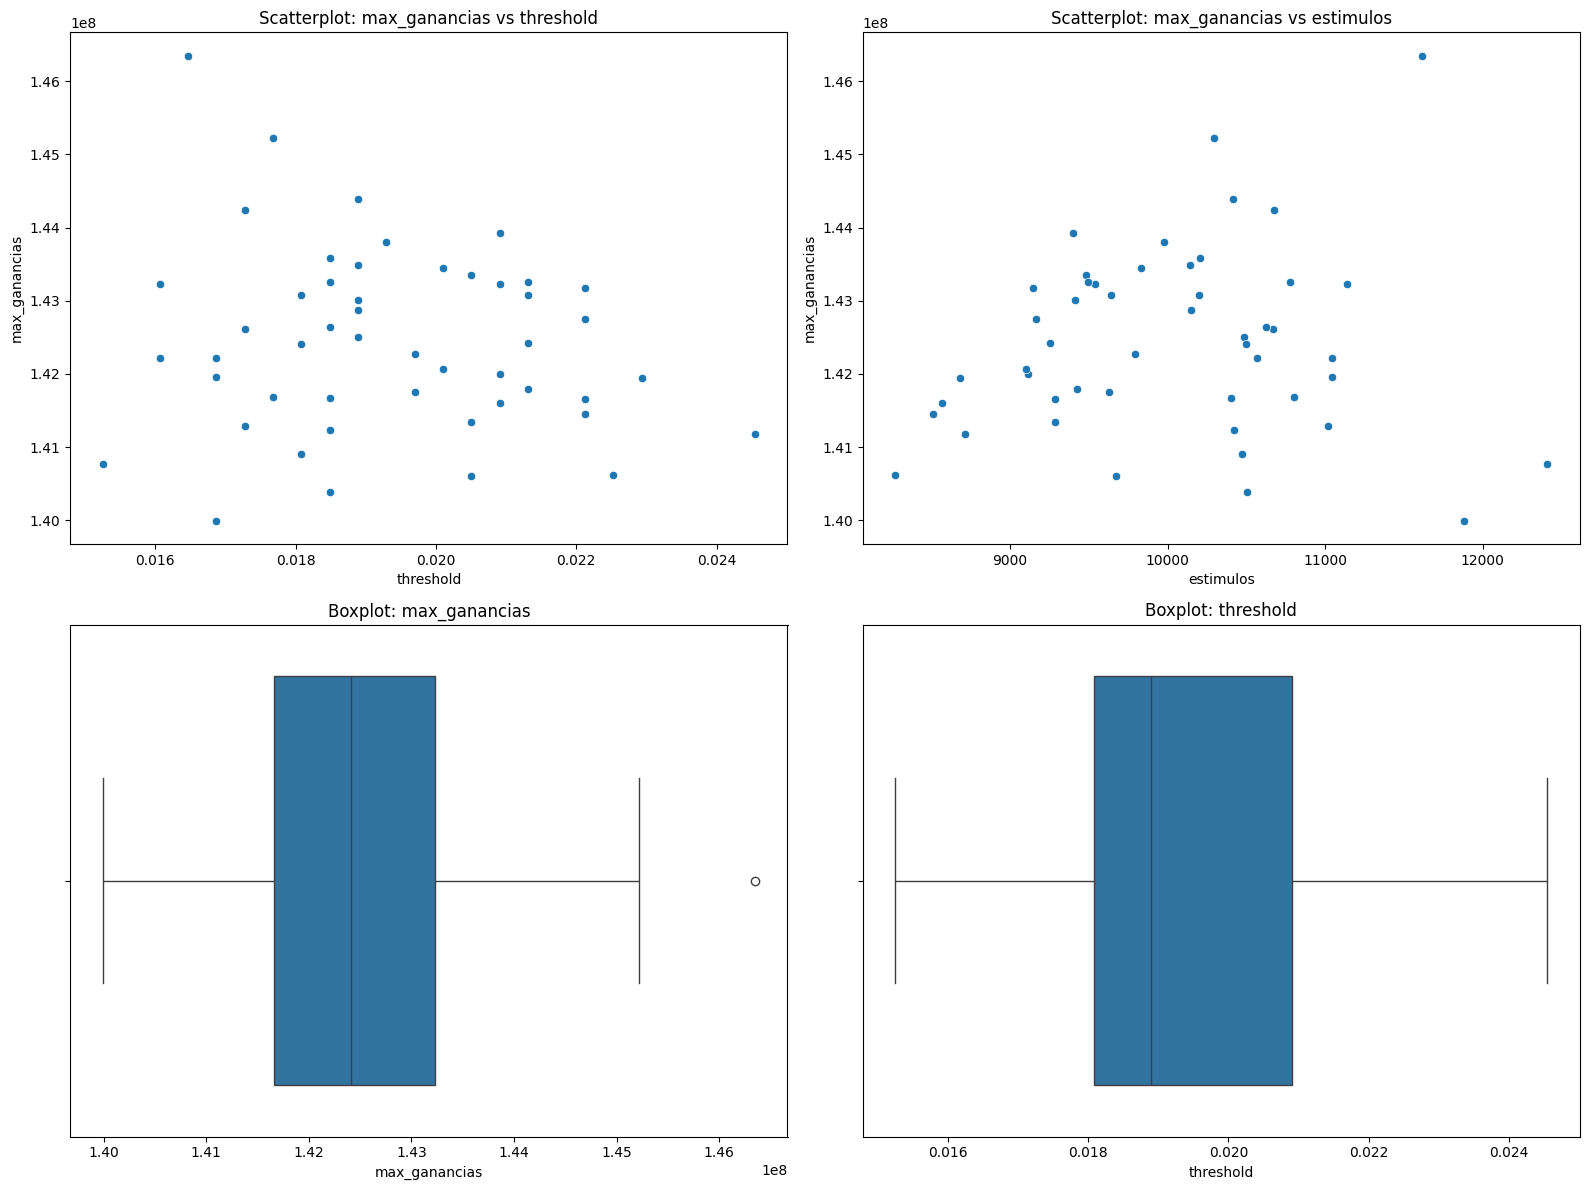

In [15]:
# Crear scatterplots, tendencias y boxplots
plt.figure(figsize=(16, 12))

# Scatterplot max_ganancias vs threshold
plt.subplot(2, 2, 1)
sns.scatterplot(x='threshold', y='max_ganancias', data=df_ganancias_semillas)
plt.title('Scatterplot: max_ganancias vs threshold')

# Scatterplot max_ganancias vs estimulos
plt.subplot(2, 2, 2)
sns.scatterplot(x='estimulos', y='max_ganancias', data=df_ganancias_semillas)
plt.title('Scatterplot: max_ganancias vs estimulos')

# Boxplot for max_ganancias
plt.subplot(2, 2, 3)
sns.boxplot(x='max_ganancias', data=df_ganancias_semillas)
plt.title('Boxplot: max_ganancias')

# Boxplot for threshold
plt.subplot(2, 2, 4)
sns.boxplot(x='threshold', data=df_ganancias_semillas)
plt.title('Boxplot: threshold')

plt.tight_layout()
plt.show()

Análisis de la estrategia de predicción

Para s semillas

In [17]:
df_s_proba.head(5)

,client,baja,clase_ternaria,proba_217163,proba_222076,proba_226989,proba_231902,proba_236815,proba_241728,proba_246641,...,proba_408770,proba_413683,proba_418596,proba_423509,proba_428422,proba_433335,proba_438248,proba_443161,proba_448074,proba_452987
0,485610,0.0,CONTINUA,0.000280,0.000253,0.000219,0.000322,0.000437,0.000258,0.000293,...,0.000359,0.000263,0.000309,0.000376,0.000221,0.000345,0.000195,0.000269,0.000310,0.000271
1,485611,0.0,CONTINUA,0.000481,0.000928,0.000552,0.001288,0.001262,0.000588,0.000482,...,0.001091,0.001051,0.000620,0.000764,0.000367,0.000922,0.000817,0.000743,0.000666,0.000753
2,485612,0.0,CONTINUA,0.000323,0.000271,0.000305,0.000210,0.000266,0.000214,0.000473,...,0.000341,0.000338,0.000197,0.000273,0.000322,0.000342,0.000461,0.000402,0.000300,0.000243
3,485613,0.0,CONTINUA,0.000278,0.000289,0.000250,0.000246,0.000238,0.000204,0.000152,...,0.000238,0.000182,0.000157,0.000245,0.000245,0.000291,0.000284,0.000209,0.000174,0.000241
4,485614,0.0,CONTINUA,0.005962,0.010551,0.005848,0.005209,0.003258,0.005408,0.006004,...,0.007221,0.007225,0.004308,0.005862,0.004819,0.007691,0.004520,0.003167,0.005553,0.010448


> Proba única

Sacando agregación de las proba:

1. mean
2. median
3. max
4. min

In [18]:
proba_columns = [col for col in df_s_proba.columns if col.startswith('proba_')]

# Calcular las nuevas columnas
df_s_proba['proba_mean'] = df_s_proba[proba_columns].mean(axis=1)
df_s_proba['proba_median'] = df_s_proba[proba_columns].median(axis=1)
df_s_proba['proba_max'] = df_s_proba[proba_columns].max(axis=1)
df_s_proba['proba_min'] = df_s_proba[proba_columns].min(axis=1)

# Mostrar el dataframe actualizado
df_s_proba.head(5)

,client,baja,clase_ternaria,proba_217163,proba_222076,proba_226989,proba_231902,proba_236815,proba_241728,proba_246641,...,proba_428422,proba_433335,proba_438248,proba_443161,proba_448074,proba_452987,proba_mean,proba_median,proba_max,proba_min
0,485610,0.0,CONTINUA,0.000280,0.000253,0.000219,0.000322,0.000437,0.000258,0.000293,...,0.000221,0.000345,0.000195,0.000269,0.000310,0.000271,0.000297,0.000280,0.000549,0.000148
1,485611,0.0,CONTINUA,0.000481,0.000928,0.000552,0.001288,0.001262,0.000588,0.000482,...,0.000367,0.000922,0.000817,0.000743,0.000666,0.000753,0.000740,0.000730,0.001616,0.000350
2,485612,0.0,CONTINUA,0.000323,0.000271,0.000305,0.000210,0.000266,0.000214,0.000473,...,0.000322,0.000342,0.000461,0.000402,0.000300,0.000243,0.000311,0.000305,0.000487,0.000197
3,485613,0.0,CONTINUA,0.000278,0.000289,0.000250,0.000246,0.000238,0.000204,0.000152,...,0.000245,0.000291,0.000284,0.000209,0.000174,0.000241,0.000229,0.000238,0.000347,0.000136
4,485614,0.0,CONTINUA,0.005962,0.010551,0.005848,0.005209,0.003258,0.005408,0.006004,...,0.004819,0.007691,0.004520,0.003167,0.005553,0.010448,0.006603,0.006004,0.011700,0.003167


Predicciones para los threshold:

* opt_mean
* opt_median
* default

In [24]:
opt_mean = 0.019367
opt_median = 0.018889
default = 0.025

print('# Variando predicción según proba única')
print('## proba_mean')

print(f'thr_opt_mean {opt_mean}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_mean
print(f'{ganancia(y, y_proba, opt_mean)}')

print(f'thr_opt_median {opt_median}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_mean
print(f'{ganancia(y, y_proba, opt_median)}')

print(f'thr_default {default}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_mean
print(f'{ganancia(y, y_proba, default)}')

print('\n# Variando predicción según proba única')
print('## proba_median')

print(f'thr_opt_mean {opt_mean}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_median
print(f'{ganancia(y, y_proba, opt_mean)}')

print(f'thr_opt_median {opt_median}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_median
print(f'{ganancia(y, y_proba, opt_median)}')

print(f'thr_default {default}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_median
print(f'{ganancia(y, y_proba, default)}')

print('\n# Variando predicción según proba única')
print('## proba_max')

print(f'thr_opt_mean {opt_mean}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_max
print(f'{ganancia(y, y_proba, opt_mean)}')

print(f'thr_opt_median {opt_median}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_max
print(f'{ganancia(y, y_proba, opt_median)}')

print(f'thr_default {default}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_max
print(f'{ganancia(y, y_proba, default)}')

print('\n# Variando predicción según proba única')
print('## proba_min')

print(f'thr_opt_mean {opt_mean}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_min
print(f'{ganancia(y, y_proba, opt_mean)}')

print(f'thr_opt_median {opt_median}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_min
print(f'{ganancia(y, y_proba, opt_median)}')

print(f'thr_default {default}')
y=df_s_proba.baja
y_proba=df_s_proba.proba_min
print(f'{ganancia(y, y_proba, default)}')

# Variando predicción según proba única
## proba_mean
thr_opt_mean 0.019367
144445000.0
thr_opt_median 0.018889
143906000.0
thr_default 0.025
140336000.0

# Variando predicción según proba única
## proba_median
thr_opt_mean 0.019367
143318000.0
thr_opt_median 0.018889
143626000.0
thr_default 0.025
139216000.0

# Variando predicción según proba única
## proba_max
thr_opt_mean 0.019367
131481000.0
thr_opt_median 0.018889
130571000.0
thr_default 0.025
138432000.0

# Variando predicción según proba única
## proba_min
thr_opt_mean 0.019367
133917000.0
thr_opt_median 0.018889
135303000.0
thr_default 0.025
126833000.0


Las ganacias máximas se da para:

proba_mean

thr_opt_mean 0.019367: 144445000.0

> Sobre cada proba

Predicciones para los threshold:

* opt_mean
* opt_median
* default

In [34]:
opt_mean = 0.019367
opt_median = 0.018889
default = 0.025

proba_columns = [col for col in df_s_proba.columns if col.startswith('proba_')]

# df predicciones segun thr mean + OR
df_s_pred_mean = df_s_proba.copy()
for col in proba_columns:
    df_s_pred_mean[col] = (df_s_pred_mean[col] >= opt_mean).astype(int)

df_s_pred_mean['predictions_any'] = (df_s_pred_mean == 1).any(axis=1).astype(int)
df_s_pred_mean['predictions_all'] = (df_s_pred_mean == 1).all(axis=1).astype(int)

ganancia_total_any = np.where(df_s_pred_mean.predictions_any == 1, 
                          np.where(df_s_pred_mean.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()

ganancia_total_all = np.where(df_s_pred_mean.predictions_all == 1, 
                          np.where(df_s_pred_mean.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()


print('# Variando predicción desde el pull de probas')
print(f'thr_opt_mean {opt_mean}')
print(f'con ANY {ganancia_total_any}')
print(f'con ALL {ganancia_total_all}')

# df predicciones segun thr median
df_s_pred_median = df_s_proba.copy()
for col in proba_columns:
    df_s_pred_median[col] = (df_s_pred_median[col] >= opt_median).astype(int)

df_s_pred_median['predictions_any'] = (df_s_pred_median == 1).any(axis=1).astype(int)
df_s_pred_median['predictions_all'] = (df_s_pred_median == 1).all(axis=1).astype(int)

ganancia_total_any = np.where(df_s_pred_median.predictions_any == 1, 
                          np.where(df_s_pred_median.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()

ganancia_total_all = np.where(df_s_pred_median.predictions_all == 1, 
                          np.where(df_s_pred_median.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()

print('\n# Variando predicción desde el pull de probas')
print(f'thr_opt_median {opt_median}')
print(f'con ANY {ganancia_total_any}')
print(f'con ALL {ganancia_total_all}')

# df predicciones segun thr default
df_s_pred_default = df_s_proba.copy()
for col in proba_columns:
    df_s_pred_default[col] = (df_s_pred_default[col] >= default).astype(int)

df_s_pred_default['predictions_any'] = (df_s_pred_default == 1).any(axis=1).astype(int)
df_s_pred_default['predictions_all'] = (df_s_pred_default == 1).all(axis=1).astype(int)

ganancia_total_any = np.where(df_s_pred_default.predictions_any == 1, 
                          np.where(df_s_pred_default.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()

ganancia_total_all = np.where(df_s_pred_default.predictions_all == 1, 
                          np.where(df_s_pred_default.baja == 2, ganancia_acierto, -costo_estimulo), 0).sum()

print('\n# Variando predicción desde el pull de probas')
print(f'thr_default {default}')
print(f'con ANY {ganancia_total_any}')
print(f'con ALL {ganancia_total_all}')

# Variando predicción desde el pull de probas
thr_opt_mean 0.019367
con ANY 128912000
con ALL 0

# Variando predicción desde el pull de probas
thr_opt_median 0.018889
con ANY 128912000
con ALL 0

# Variando predicción desde el pull de probas
thr_default 0.025
con ANY 128912000
con ALL 0


Parece que esto no tiene efecto alguno, o que estoy cometiendo algún error.

### Entrenamiento con la semilla original

Del pipeline de optimización

In [29]:
selected_model = pipeline_xgb_fe1_reg.best_model

y_pred_proba = selected_model.predict_proba(X_test_imp)

In [46]:
test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_baja2' : y_pred_proba[:,2]
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}

test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

In [47]:
test_results

,client,baja,proba_baja2,clase_ternaria
0,485610,0.0,0.000550,CONTINUA
1,485611,0.0,0.001157,CONTINUA
2,485612,0.0,0.000348,CONTINUA
3,485613,0.0,0.000390,CONTINUA
4,485614,0.0,0.010729,CONTINUA
...,...,...,...,...
164085,981941,0.0,0.000091,CONTINUA
164086,981942,0.0,0.000243,CONTINUA
164087,981943,0.0,0.000108,CONTINUA
164088,981944,0.0,0.000073,CONTINUA


El threshold inicial es de 0.025 (2.5 %)

Probaremos que ocurre con +/- 2.5 %

Ganancias para distintos thresholds

In [61]:
thrs = []
ganancias = []
estimulos = []

for thr in np.linspace(0.01, 0.05, 100):
    gain = ganancia(test_results.baja, test_results.proba_baja2, thr)
    esti = np.where(test_results.proba_baja2 >= thr, 1, 0).sum()

    thrs.append(thr)
    ganancias.append(gain)
    estimulos.append(esti)

df_ganancias = pd.DataFrame({
                            'threshold': thrs,
                            'ganancias': ganancias,
                            'estimulos': estimulos
                        })


In [62]:
df_ganancias

,threshold,ganancias,estimulos
0,0.010000,127309000.0,17133
1,0.010404,128982000.0,16614
2,0.010808,130529000.0,16113
3,0.011212,131747000.0,15659
4,0.011616,132664000.0,15248
...,...,...,...
95,0.048384,114681000.0,3737
96,0.048788,114646000.0,3702
97,0.049192,114597000.0,3669
98,0.049596,114345000.0,3625


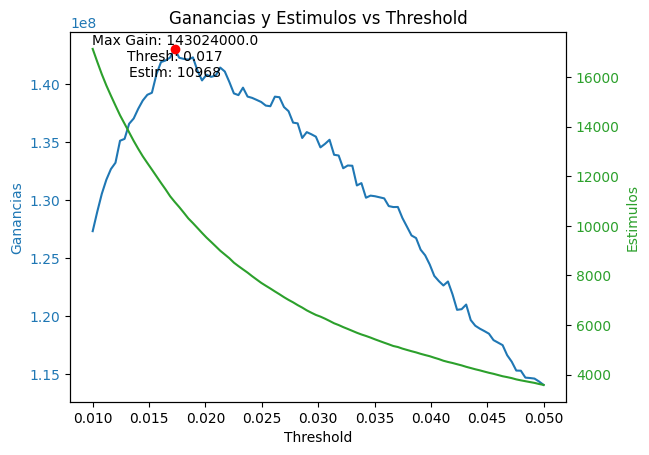

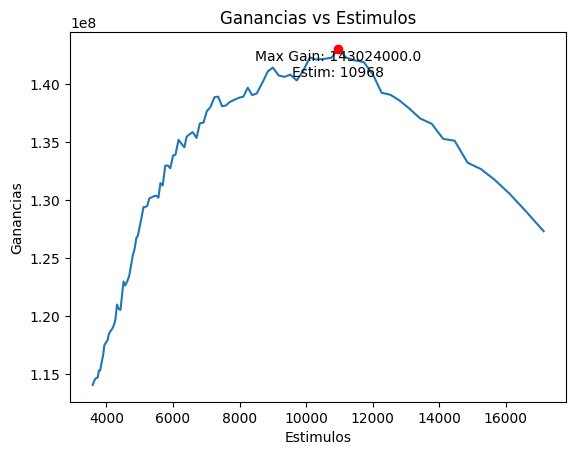

In [63]:
# Plot A: threshold on x-axis, ganancias on left y-axis, estimulos on right y-axis
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Ganancias', color='tab:blue')
ax1.plot(df_ganancias['threshold'], df_ganancias['ganancias'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Estimulos', color='tab:green')
ax2.plot(df_ganancias['threshold'], df_ganancias['estimulos'], color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Highlight maximum gain
max_gain_idx = df_ganancias['ganancias'].idxmax()
max_gain_threshold = df_ganancias['threshold'][max_gain_idx]
max_estimulos = df_ganancias['estimulos'][max_gain_idx]
max_gain = df_ganancias['ganancias'][max_gain_idx]

ax1.scatter(max_gain_threshold, max_gain, color='red', zorder=5)
ax1.annotate(f"Max Gain: {max_gain}\nThresh: {max_gain_threshold:.3f}\nEstim: {max_estimulos}", 
             (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20), ha='center')

plt.title('Ganancias y Estimulos vs Threshold')
plt.show()

# Plot B: Estimulos on x-axis, Ganancias on y-axis
plt.figure()

plt.plot(df_ganancias['estimulos'], df_ganancias['ganancias'], color='tab:blue')
plt.xlabel('Estimulos')
plt.ylabel('Ganancias')

# Highlight maximum gain
plt.scatter(max_estimulos, max_gain, color='red', zorder=5)
plt.annotate(f"Max Gain: {max_gain}\nEstim: {max_estimulos}", 
             (max_estimulos, max_gain), textcoords="offset points", xytext=(0,-20), ha='center')

plt.title('Ganancias vs Estimulos')
plt.show()

____

______